In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [191]:
# load in pre-cleaned deaths data for Texas and comparison states
deaths = pd.read_csv("05_cleaned_data/deaths_tx.csv")


In [192]:
# two separate dfs - one for texas and one for comp states

texas = deaths[deaths["StateName"] == "Texas"]
comp = deaths[deaths["StateName"] != "Texas"]

### Helper functions 

In [193]:
# function to select only overdose records
# double check this

def select_overdose(record):
    """Simple function to select only overdose records"""

    if record == "All other non-drug and non-alcohol causes":
        return 0

    if record == "All other alcohol-induced causes":
        return 0

    if record == "All other drug-induced causes":
        return 0

    if record == "Alcohol poisonings (overdose) (X45, X65, Y15)":
        return 0

    if record == "Drug poisonings (overdose) Unintentional (X40-X44)":
        return 1

    if record == "Drug poisonings (overdose) Suicide (X60-X64)":
        return 1

    if record == "Drug poisonings (overdose) Undetermined (Y10-Y14)":
        return 1

    else:
        return "error"
    

# copy to fix the dreaded "A value is trying to be set on a copy of a slice" error
tx_deaths = texas.copy()
comp_deaths = comp.copy()

# apply new function to our df
tx_deaths["overdose"] = tx_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))
comp_deaths["overdose"] = comp_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))

# filter accordingly based on new column
tx_deaths = tx_deaths[tx_deaths["overdose"] != 0]
comp_deaths = comp_deaths[comp_deaths["overdose"] != 0]

In [194]:
# calculate overdoses per 100_000 residents

tx_deaths["overdose_per_100k"] = tx_deaths["Deaths"] / tx_deaths["Population"] * 100_000
comp_deaths["overdose_per_100k"] = comp_deaths["Deaths"] / comp_deaths["Population"] * 100_000

In [195]:
tx_result = tx_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
comp_result = comp_deaths.groupby(["Year", "StateName", "CountyName"])["overdose_per_100k"].sum().reset_index()

# keep validating num counties


# recent change - added county to both results above, removed state from comp_result

In [196]:
comp_result[comp_result["StateName"] == "Arkansas"].groupby("Year")["overdose_per_100k"].mean()

Year
2004.0     9.546982
2005.0     9.061194
2006.0     8.093736
2007.0    12.526991
2008.0    11.997588
2009.0    13.608821
2010.0    12.148777
Name: overdose_per_100k, dtype: float64

In [197]:
comp_result[comp_result["StateName"] == "Kansas"].groupby("Year")["overdose_per_100k"].mean()

Year
2004.0     8.434598
2005.0     8.751961
2006.0     8.234585
2007.0     8.932216
2008.0     8.055972
2009.0    10.410575
2010.0     8.761948
Name: overdose_per_100k, dtype: float64

In [198]:
comp_result[comp_result["StateName"] == "Louisiana"].groupby("Year")["overdose_per_100k"].mean()

Year
2004.0    14.676815
2005.0    18.484715
2006.0    19.532244
2007.0    19.256800
2008.0    16.989931
2009.0    14.017331
2010.0    14.589543
Name: overdose_per_100k, dtype: float64

In [199]:
comp_result[comp_result["StateName"] == "New Mexico"].groupby("Year")["overdose_per_100k"].mean()

Year
2004.0    22.131525
2005.0    20.184407
2006.0    22.650309
2007.0    20.951433
2008.0    24.290379
2009.0    21.549887
2010.0    21.793309
Name: overdose_per_100k, dtype: float64

In [200]:
comp_result[comp_result["StateName"] == "Oklahoma"].groupby("Year")["overdose_per_100k"].mean()

Year
2004.0    15.492609
2005.0    14.000787
2006.0    19.823879
2007.0    17.120240
2008.0    17.527223
2009.0    23.172495
2010.0    19.718064
Name: overdose_per_100k, dtype: float64

In [201]:
tx_result.groupby("Year")["overdose_per_100k"].mean()

Year
2004.0     8.102934
2005.0     9.220124
2006.0    12.833851
2007.0     9.688599
2008.0    10.315215
2009.0    11.567287
2010.0    10.657727
Name: overdose_per_100k, dtype: float64

In [202]:
comp_result.groupby("Year")["overdose_per_100k"].mean()

Year
2004.0    15.332948
2005.0    16.440722
2006.0    17.968616
2007.0    17.743348
2008.0    16.961625
2009.0    18.134355
2010.0    16.380802
Name: overdose_per_100k, dtype: float64

In [203]:
# idea for counties -> histogram of population, drop the outliers?

#plt.hist(tx_deaths["Population"], bins=20)

In [204]:
tx_result = tx_result.groupby("Year")["overdose_per_100k"].mean().reset_index()
comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [205]:
# idea for counties -> histogram of population, drop the outliers?

In [206]:
comp_result

,Year,overdose_per_100k
0,2004.0,15.332948
1,2005.0,16.440722
2,2006.0,17.968616
3,2007.0,17.743348
4,2008.0,16.961625
5,2009.0,18.134355
6,2010.0,16.380802


In [207]:
#tx_result = tx_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
#comp_result = comp_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
#
#tx_result = tx_result.groupby("Year")["overdose_per_100k"].mean().reset_index()
#comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [208]:
# collapse state column with a mean aggregation
# gives us the average overdoses of our comparison states over the years
#comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [209]:
# create a scale for number of years before and after 2007 (target year)

def scale_years(year):
    if year == 2004:
        return -3
    if year == 2005:
        return -2
    if year == 2006:
        return -1
    if year == 2007:
        return 0
    if year == 2008:
        return 1
    if year == 2009:
        return 2
    if year == 2010:
        return 3

tx_result["year relative to policy"] = tx_result["Year"].apply(lambda x: scale_years(x))
comp_result["year relative to policy"] = comp_result["Year"].apply(lambda x: scale_years(x))

# double check no nulls in "year relative to policy"

assert (tx_result["year relative to policy"].isnull().sum() == 0)
assert (comp_result["year relative to policy"].isnull().sum() == 0)

# doing this in case the float == int comparison causes issues

## Pre-post plot - overdoses per 100k through the years

In [210]:
# split into before 2007 and after 2007

tx_b4 = tx_result[tx_result["Year"] < 2007]
tx_after = tx_result[tx_result["Year"] >= 2007]


tx_after = tx_after[tx_after["Year"] != 2007] # may need to handle this differently

In [211]:
from sklearn.linear_model import LinearRegression 

regressor_b4 = LinearRegression() 
regressor_after = LinearRegression()


X_b4 = np.array(tx_b4["year relative to policy"]).reshape(-1, 1)
y_b4 = np.array(tx_b4["overdose_per_100k"]).reshape(-1, 1)

X_after = np.array(tx_after["year relative to policy"]).reshape(-1, 1)
y_after = np.array(tx_after["overdose_per_100k"]).reshape(-1, 1)


regressor_b4.fit(X_b4,y_b4) 
regressor_after.fit(X_after,y_after) 


y_pred_b4 = regressor_b4.predict(X_b4)
y_pred_after = regressor_after.predict(X_b4)



In [212]:
y_pred_b4

array([[ 7.68684469],
       [10.05230327],
       [12.41776185]])

In [213]:
y_pred_after

array([[ 9.99046349],
       [10.16171941],
       [10.33297534]])

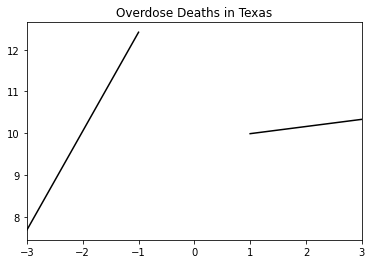

In [214]:
plt.xlim(-3, 3)
#plt.ylim(0, 500)

plt.title("Overdose Deaths in Texas")

plt.plot(X_b4, y_pred_b4,color='k')
plt.plot(X_after, y_pred_after,color='k')

# plot avg value in each year


In [215]:
# diff in diff

In [216]:
comp_b4 = comp_result[comp_result["Year"] < 2007]
comp_after = comp_result[comp_result["Year"] >= 2007]

comp_after = comp_after[comp_after["Year"] != 2007] # may need to handle this differently


In [217]:
regressor_b4 = LinearRegression() 
regressor_after = LinearRegression()


X_b4 = np.array(comp_b4["year relative to policy"]).reshape(-1, 1)
y_b4 = np.array(comp_b4["overdose_per_100k"]).reshape(-1, 1)

X_after = np.array(comp_after["year relative to policy"]).reshape(-1, 1)
y_after = np.array(comp_after["overdose_per_100k"]).reshape(-1, 1)


regressor_b4.fit(X_b4,y_b4) 
regressor_after.fit(X_after,y_after) 


y_pred_b4 = regressor_b4.predict(X_b4)
y_pred_after = regressor_after.predict(X_b4)



In [218]:
y_pred_b4

array([[15.2629278 ],
       [16.58076203],
       [17.89859626]])

In [219]:
y_pred_after

array([[18.61098514],
       [18.32057354],
       [18.03016194]])

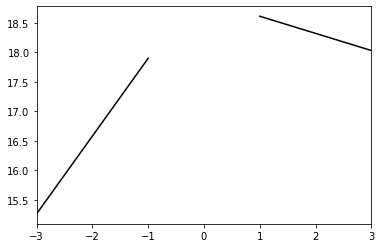

In [220]:
plt.xlim(-3, 3)
#plt.ylim(0, 500)

plt.plot(X_b4, y_pred_b4,color='k')
plt.plot(X_after, y_pred_after,color='k')


In [221]:
# new method after working more with reshaping exercises
# using statsmodels now, wrapping stuff in functions
# thinking it could be easier to break it down by task

## Helper functions

1) vertical_line()
    - takes in a year and plots a vertical line at that year
2) get_charts()
    - takes in two dataframes (one for before policy, one for after)
    - returns chart for each
    - not much utility by itself - used as a parameter for our get_fit() function

In [222]:
x = "Year"
y = "overdose_per_100k"

In [223]:
def vertical_line(year):
    """Function to plot a vertical line at year of policy implementation"""
    line = alt.Chart(pd.DataFrame({
    'Date': [year],
    'color': ["black"]
    })).mark_rule().encode(
    x='Date:Q', # use q for "quantitative" - as per altair docs
    color=alt.Color('color:N', scale=None)
    )

    return line

In [224]:
# test function
vertical_line(2004)

c:\Users\abzdel\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


alt.Chart(...)

In [273]:
def get_charts(b4, after, title_b4, title_after):
    """
    Function to plot the pre and post charts.
    Will not use in final plot - used as a baseline for our fit charts later.

    """

    base_before = (
        alt.Chart(b4)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_b4)
        
    )

    base_after = (
        alt.Chart(after)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_after)
    )

    return base_before, base_after

In [274]:
# test the function
# may remove title parameters later - not really necessary as we aren't plotting this part in our final analysis
# however, if we can't add a title to our fit/regression line charts, we may need to add them here
base_before, base_after = get_charts(b4 = tx_b4, after = tx_after, title_b4 = "deaths before policy", title_after="deaths after policy")
base_before + base_after

alt.LayerChart(...)

In [ ]:
# starting here in final report
# no longer calculating base chart above - just adding in regression line at same time

In [248]:
def get_preds(df, x, y):

    # init new empty df for our predictions
    predictions = pd.DataFrame()

    # fit our model and predict values
    model = smf.ols(f"{y} ~ {x}", data=df).fit()
    model_predict = model.get_prediction(df[x])

    # save predictions back to df, calculate confidence intervals
    predictions["overdose_per_100k"] = model.predict(df[x])
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=0.05)

    # save original year columns to new predictions df
    predictions["Year"] = df["Year"]
    predictions["year relative to policy"] = df["year relative to policy"]
    return predictions

In [249]:
tx_b4_preds = get_preds(tx_b4, x, y)
tx_after_preds = get_preds(tx_after, x, y)

In [232]:
        .mark_errorband()
        .encode(
            x=x,
            y=alt.Y("ci_low", title=y),
            y2="ci_high",
        )

SyntaxError: invalid syntax (Temp/ipykernel_37456/1009719505.py, line 1)

In [271]:
def get_charts(b4, after, title_b4, title_after):
    """
    Function to plot the pre and post charts.
    Will not use in final plot - used as a baseline for our fit charts later.

    """

    base_before = (
        alt.Chart(b4)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_b4).transform_regression("year relative to policy", "overdose_per_100k")
    .mark_line()
    .encode(color=alt.value("red"))
        
    )

    base_after = (
        alt.Chart(after)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
            
        )
        .properties(title=title_after).transform_regression("year relative to policy", "overdose_per_100k")
    .mark_line()
    .encode(color=alt.value("red"))
    )

    return base_before, base_after

In [272]:
# test the function
# may remove title parameters later - not really necessary as we aren't plotting this part in our final analysis
# however, if we can't add a title to our fit/regression line charts, we may need to add them here
base_before, base_after = get_charts(b4 = tx_b4_preds, after = tx_after_preds, title_b4 = "deaths before policy", title_after="deaths after policy")
base_before + base_after

alt.LayerChart(...)

In [236]:
# ignore below for now,
# making separate predictions dataframe above

In [245]:
def get_fits(chart_b4, chart_after, b4_preds, after_preds):
    """
    Function to plot the regression lines for the pre and post charts.
    """

    fit_tx_b4 = (
    chart_b4.transform_regression("year relative to policy", "overdose_per_100k")
    .mark_line()
    .encode(color=alt.value("red"))

    )#.mark_errorband()



    fit_tx_after = (
    chart_after.transform_regression("year relative to policy", "overdose_per_100k")
    .mark_line()
    .encode(color=alt.value("red"))
    )

    return fit_tx_b4, fit_tx_after


# test function
fit_b4, fit_after = get_fits(chart_b4 = base_before, chart_after = base_after)
fit_b4 + fit_after

In [251]:
band_b4 = alt.Chart(tx_b4_preds).mark_errorband(extent='ci').encode(
    x=alt.X('Year'),
    y=alt.Y('overdose_per_100k'))


band_after = alt.Chart(tx_after_preds).mark_errorband(extent='ci').encode(
    x=alt.X('Year'),
    y=alt.Y('overdose_per_100k'))

In [254]:
fit_b4 + fit_after

c:\Users\abzdel\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


alt.LayerChart(...)

In [ ]:
error_bars = base_before.mark_rule().encode(
    x='ci0(overdose_per_100k):Q',
    x2='ci1(overdose_per_100k):Q',
)


In [ ]:
error_bars

alt.Chart(...)

In [ ]:
band = alt.Chart(base_before).mark_area(
    opacity=0.5
).encode(
    x='overdose_per_100k:Q',
    y='lower:N',
    y2='upper:N'
)

In [ ]:
band

c:\Users\abzdel\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\vegalite\v4\api.py:101: UserWarning: data of type <class 'altair.vegalite.v4.api.Chart'> not recognized


SchemaValidationError: Invalid specification

        altair.vegalite.v4.api.Chart->0, validating 'anyOf'

        {'data': {'name': 'data-a2702a7e9e889a7f9b444e25420e1d1c'}, 'mark': 'point', 'encoding': {'x': {'field': 'year relative to policy', 'scale': {'zero': False}, 'type': 'quantitative'}, 'y': {'field': 'overdose_per_100k', 'scale': {'zero': False}, 'type': 'quantitative'}}, 'title': 'deaths before policy'} is not valid under any of the given schemas
        

alt.Chart(...)

In [ ]:
tx_b4

,Year,overdose_per_100k,year relative to policy
0,2004.0,8.102934,-3
1,2005.0,9.220124,-2
2,2006.0,12.833851,-1


In [ ]:
mean_points = alt.Chart(tx_b4).mark_circle(color='black').encode(
    alt.X("overdoses_per_100k:Q", bin=True),
    y='year relative to policy:Q',
)

error_bars = alt.Chart(tx_after).mark_errorbar(extent='ci').encode(
    alt.X("overdoses_per_100k:Q", bin=True),
    y='year relative to policy:Q',
)

In [ ]:
mean_points + error_bars

alt.LayerChart(...)

In [ ]:
fit_b4 + fit_after + error_bars

alt.LayerChart(...)